In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json, copy, tqdm, pickle
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, get_sun
from astropy.coordinates import Angle
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
from alerts import get_alerts
from style import output_folder, big_fontsize, base_width, base_height, dpi, CB_color_cycle
import seaborn as sns
from astropy.time import Time

from scipy.optimize import root
from scipy.interpolate import interp1d
from scipy.integrate import quad

from flarestack.cosmo import get_rate, define_cosmology_functions
plt.style.use('tableau-colorblind10')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define some style parameters

In [2]:
rates = [
    #("TDE", get_rate("tde")),
    ("GRB", get_rate("GRB")),
#     ("TDE (Jetted)", get_rate("tde", rate_name="sun_15_jetted")),
    #("CCSN (Madau)", get_rate("ccsn", rate_name="madau_14", evolution_name="madau_14", kcc_name="madau_14")),
    ("SFR", get_rate("ccsn", rate_name="strolger_15", evolution_name="strolger_15", kcc_name="strolger_15")),
]

labels = {
    "TDE": "TDE-like",
    "GRB": "GRB-like",
    "CCSN (Strolger)": "SFR-like"
}

colors = {
    "TDE": CB_color_cycle[0],
    "GRB": CB_color_cycle[1],
    "CCSN (Madau)": CB_color_cycle[3],
    "CCSN (Strolger)": CB_color_cycle[5],
    "CCSN": CB_color_cycle[5],
    "SFR": CB_color_cycle[5]
}

In [128]:
nsteps = 1e4
zrange, step = np.linspace(0.0, 500, int(nsteps + 1), retstep=True)
cdf_mpc = dict()
zplot = 0.5*(zrange[1:] + zrange[:-1])
dlum_plot = cosmo.luminosity_distance(zplot)

for label, rate in rates:
    
    rate_per_z, nu_flux_per_z, nu_flux_per_source, cumulative_nu_flux = \
            define_cosmology_functions(rate, 1., gamma=2.0)

    y = [0] + [x.value for x in cumulative_nu_flux(zplot)]
    y = np.array(y)/y[-1]
    dls = [0.] + [dl.value for dl in dlum_plot[1:]]
    cdf_mpc[label] = interp1d(dls, [0.] + list(y))

In [127]:
len(y)

9998

In [116]:
max(dls)

6906082.303502253

In [97]:
cosmo.luminosity_distance(100)

<Quantity 1306348.73498667 Mpc>

In [6]:
average_absolute_magnitudes = {
    'TDE': -19.5,
    'SN IIn': -18.53
#     'SN Ib': -17.45,
#     'SN Ic': -17.66,
    
}

mags_labels = {
    'SN IIn': 'CCSN',
    'TDE': 'TDE'
}

mag_label_map = np.array([
    ('SN IIn', 'CCSN'),
    ('TDE', 'TDE'),
    ('GRB', 'GRB'),
    ('SN IIn', 'SFR')
])

## Define some general functions

In [7]:
def abs_mag(z, lim_mag):
    
    dl = cosmo.luminosity_distance(z=z).to(u.pc)
    
    ab_mag = lim_mag - 5. * np.log10(dl/(10.*u.pc))
    
    return ab_mag.value

def max_dl(ab_mag, lim_mag):
    
    dl = (10.**(0.2*(lim_mag - ab_mag))) * (10.*u.pc)
    
    return dl.to(u.Mpc)

def abs_mag_to_lum(ab_mag, wl):
    am = (ab_mag * u.ABmag).to(u.Jansky)
    f = (constants.c / wl).to("Hz")
    lum = (am * f * (4. * np.pi * (10. * u.pc)**2.)).to("erg s-1")
    return lum

## Load alerts

In [8]:
alerts = get_alerts()

In [167]:
m = (~alerts.retracted)
use_alerts = alerts[m]

In [168]:
hese_m = use_alerts.Class == 'HESE'
use_alerts.loc[hese_m, 'Signalness'] = 0.

In [169]:
N = len(use_alerts.Event.unique())
print(N, 'alerts used')

73 alerts used


## Define parameters for other instruments

In [150]:
full_sky_sqd = 41252.961
# the list elements: observable sky fraction, completeness magnitude, color, linestyle
instruments = {
    'ZTF': [23675 / full_sky_sqd, 20.8, CB_color_cycle[5], "-."],
    'LSST': [20000 / full_sky_sqd, 25, CB_color_cycle[4], "--"],
    'All-Sky LSST': [1, 25, CB_color_cycle[6], ":"]
}
instruments

{'ZTF': [0.5738981984832555, 20.8, '#984ea3', '-.'],
 'LSST': [0.48481368404076497, 25, '#a65628', '--'],
 'All-Sky LSST': [1, 25, '#999999', ':']}

In [151]:
uls = dict()
ts = ['24h']
Ntrials = 100


for inst, info in instruments.items():
    
    print(f'---------- {inst} -----------')
    
    ul_samples = list()
    
    for i in tqdm.tqdm(range(Ntrials)):
        
        sample = observed.sample(frac=info[0])

        def P_det(f, t):
            P = 1
            for i, r in sample.iterrows():
                if r.Event == 'IC160731A' and r.Class == 'HESE':
                    continue
                P *= 1 - r.Signalness * r[f'{t} coverage']/100 * f
            return P

        fs = np.linspace(0, 1, 1000)
        Ps = {t: [P_det(f, t) for f in fs] for t in ts}

        inverse_pdet = {t: interp1d(iPs, fs) for t, iPs in Ps.items()}

        cl = 0.9
        pval = 1-cl

        ul_sample = {t: ip(pval) for t, ip in inverse_pdet.items()} 
        for t, iul in ul_sample.items():
            print(f'{t}: Only {iul*100:.1f}% ({cl*100:.0f}% CL) can lie above our limiting magnitude.')
            
        """
        for t, iPs in Ps.items():
            fig, ax = plt.subplots()#figsize=(base_width, base_height), dpi=dpi)
            ax.plot(fs, iPs, color='k')
            plt.axhline(pval)
            plt.axvline(ul_sample[t])
            # plt.yscale('log')
            ax.set_xlim((0, 1))
            ax.set_title(t)
            plt.show()
            plt.close()
        """
            
        ul_samples.append(ul_sample)
            
    ul = {t: np.median([ul_sample[t] for ul_sample in ul_samples])
         for t in ts}
        
    uls[inst] = ul

---------- ZTF -----------


  1%|█▍                                                                                                                                            | 1/100 [00:01<02:04,  1.26s/it]

24h: Only 27.4% (90% CL) can lie above our limiting magnitude.


  2%|██▊                                                                                                                                           | 2/100 [00:02<02:04,  1.27s/it]

24h: Only 24.1% (90% CL) can lie above our limiting magnitude.


  3%|████▎                                                                                                                                         | 3/100 [00:03<02:02,  1.26s/it]

24h: Only 23.1% (90% CL) can lie above our limiting magnitude.


  4%|█████▋                                                                                                                                        | 4/100 [00:05<02:00,  1.26s/it]

24h: Only 23.0% (90% CL) can lie above our limiting magnitude.


  5%|███████                                                                                                                                       | 5/100 [00:06<01:59,  1.26s/it]

24h: Only 28.2% (90% CL) can lie above our limiting magnitude.


  6%|████████▌                                                                                                                                     | 6/100 [00:07<01:57,  1.25s/it]

24h: Only 32.5% (90% CL) can lie above our limiting magnitude.


  7%|█████████▉                                                                                                                                    | 7/100 [00:08<01:57,  1.26s/it]

24h: Only 21.9% (90% CL) can lie above our limiting magnitude.


  8%|███████████▎                                                                                                                                  | 8/100 [00:10<01:55,  1.25s/it]

24h: Only 25.3% (90% CL) can lie above our limiting magnitude.


  9%|████████████▊                                                                                                                                 | 9/100 [00:11<01:54,  1.26s/it]

24h: Only 23.0% (90% CL) can lie above our limiting magnitude.


 10%|██████████████                                                                                                                               | 10/100 [00:12<01:52,  1.25s/it]

24h: Only 26.7% (90% CL) can lie above our limiting magnitude.


 11%|███████████████▌                                                                                                                             | 11/100 [00:13<01:51,  1.25s/it]

24h: Only 32.4% (90% CL) can lie above our limiting magnitude.


 12%|████████████████▉                                                                                                                            | 12/100 [00:15<01:49,  1.25s/it]

24h: Only 23.1% (90% CL) can lie above our limiting magnitude.


 13%|██████████████████▎                                                                                                                          | 13/100 [00:16<01:48,  1.25s/it]

24h: Only 27.3% (90% CL) can lie above our limiting magnitude.


 14%|███████████████████▋                                                                                                                         | 14/100 [00:17<01:47,  1.25s/it]

24h: Only 26.4% (90% CL) can lie above our limiting magnitude.


 15%|█████████████████████▏                                                                                                                       | 15/100 [00:18<01:46,  1.25s/it]

24h: Only 33.7% (90% CL) can lie above our limiting magnitude.


 16%|██████████████████████▌                                                                                                                      | 16/100 [00:20<01:45,  1.25s/it]

24h: Only 25.3% (90% CL) can lie above our limiting magnitude.


 17%|███████████████████████▉                                                                                                                     | 17/100 [00:21<01:45,  1.27s/it]

24h: Only 23.7% (90% CL) can lie above our limiting magnitude.


 18%|█████████████████████████▍                                                                                                                   | 18/100 [00:22<01:44,  1.28s/it]

24h: Only 23.4% (90% CL) can lie above our limiting magnitude.


 19%|██████████████████████████▊                                                                                                                  | 19/100 [00:23<01:44,  1.29s/it]

24h: Only 24.0% (90% CL) can lie above our limiting magnitude.


 20%|████████████████████████████▏                                                                                                                | 20/100 [00:25<01:44,  1.30s/it]

24h: Only 24.9% (90% CL) can lie above our limiting magnitude.


 21%|█████████████████████████████▌                                                                                                               | 21/100 [00:26<01:42,  1.30s/it]

24h: Only 26.4% (90% CL) can lie above our limiting magnitude.


 22%|███████████████████████████████                                                                                                              | 22/100 [00:27<01:40,  1.29s/it]

24h: Only 28.8% (90% CL) can lie above our limiting magnitude.


 23%|████████████████████████████████▍                                                                                                            | 23/100 [00:29<01:39,  1.30s/it]

24h: Only 26.9% (90% CL) can lie above our limiting magnitude.


 24%|█████████████████████████████████▊                                                                                                           | 24/100 [00:30<01:40,  1.32s/it]

24h: Only 28.2% (90% CL) can lie above our limiting magnitude.


 25%|███████████████████████████████████▎                                                                                                         | 25/100 [00:31<01:37,  1.30s/it]

24h: Only 22.9% (90% CL) can lie above our limiting magnitude.


 26%|████████████████████████████████████▋                                                                                                        | 26/100 [00:33<01:35,  1.29s/it]

24h: Only 23.2% (90% CL) can lie above our limiting magnitude.


 27%|██████████████████████████████████████                                                                                                       | 27/100 [00:34<01:32,  1.27s/it]

24h: Only 25.1% (90% CL) can lie above our limiting magnitude.


 28%|███████████████████████████████████████▍                                                                                                     | 28/100 [00:35<01:31,  1.27s/it]

24h: Only 28.2% (90% CL) can lie above our limiting magnitude.


 29%|████████████████████████████████████████▉                                                                                                    | 29/100 [00:36<01:30,  1.27s/it]

24h: Only 21.5% (90% CL) can lie above our limiting magnitude.


 30%|██████████████████████████████████████████▎                                                                                                  | 30/100 [00:38<01:28,  1.26s/it]

24h: Only 27.5% (90% CL) can lie above our limiting magnitude.


 31%|███████████████████████████████████████████▋                                                                                                 | 31/100 [00:39<01:26,  1.25s/it]

24h: Only 23.8% (90% CL) can lie above our limiting magnitude.


 32%|█████████████████████████████████████████████                                                                                                | 32/100 [00:40<01:25,  1.25s/it]

24h: Only 31.1% (90% CL) can lie above our limiting magnitude.


 33%|██████████████████████████████████████████████▌                                                                                              | 33/100 [00:41<01:23,  1.25s/it]

24h: Only 22.4% (90% CL) can lie above our limiting magnitude.


 34%|███████████████████████████████████████████████▉                                                                                             | 34/100 [00:43<01:22,  1.25s/it]

24h: Only 25.7% (90% CL) can lie above our limiting magnitude.


 35%|█████████████████████████████████████████████████▎                                                                                           | 35/100 [00:44<01:20,  1.24s/it]

24h: Only 28.8% (90% CL) can lie above our limiting magnitude.


 36%|██████████████████████████████████████████████████▊                                                                                          | 36/100 [00:45<01:19,  1.25s/it]

24h: Only 26.5% (90% CL) can lie above our limiting magnitude.


 37%|████████████████████████████████████████████████████▏                                                                                        | 37/100 [00:46<01:18,  1.24s/it]

24h: Only 25.5% (90% CL) can lie above our limiting magnitude.


 38%|█████████████████████████████████████████████████████▌                                                                                       | 38/100 [00:48<01:17,  1.25s/it]

24h: Only 29.2% (90% CL) can lie above our limiting magnitude.


 39%|██████████████████████████████████████████████████████▉                                                                                      | 39/100 [00:49<01:15,  1.24s/it]

24h: Only 24.4% (90% CL) can lie above our limiting magnitude.


 40%|████████████████████████████████████████████████████████▍                                                                                    | 40/100 [00:50<01:14,  1.24s/it]

24h: Only 27.3% (90% CL) can lie above our limiting magnitude.


 41%|█████████████████████████████████████████████████████████▊                                                                                   | 41/100 [00:51<01:13,  1.24s/it]

24h: Only 26.4% (90% CL) can lie above our limiting magnitude.


 42%|███████████████████████████████████████████████████████████▏                                                                                 | 42/100 [00:53<01:12,  1.25s/it]

24h: Only 25.3% (90% CL) can lie above our limiting magnitude.


 43%|████████████████████████████████████████████████████████████▋                                                                                | 43/100 [00:54<01:10,  1.24s/it]

24h: Only 31.3% (90% CL) can lie above our limiting magnitude.


 44%|██████████████████████████████████████████████████████████████                                                                               | 44/100 [00:55<01:09,  1.25s/it]

24h: Only 26.7% (90% CL) can lie above our limiting magnitude.


 45%|███████████████████████████████████████████████████████████████▍                                                                             | 45/100 [00:56<01:08,  1.24s/it]

24h: Only 23.9% (90% CL) can lie above our limiting magnitude.


 46%|████████████████████████████████████████████████████████████████▊                                                                            | 46/100 [00:57<01:07,  1.25s/it]

24h: Only 25.4% (90% CL) can lie above our limiting magnitude.


 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 47/100 [00:59<01:05,  1.24s/it]

24h: Only 28.8% (90% CL) can lie above our limiting magnitude.


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 48/100 [01:00<01:04,  1.24s/it]

24h: Only 25.2% (90% CL) can lie above our limiting magnitude.


 49%|█████████████████████████████████████████████████████████████████████                                                                        | 49/100 [01:01<01:03,  1.24s/it]

24h: Only 24.2% (90% CL) can lie above our limiting magnitude.


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 50/100 [01:02<01:02,  1.25s/it]

24h: Only 27.6% (90% CL) can lie above our limiting magnitude.


 51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 51/100 [01:04<01:00,  1.24s/it]

24h: Only 23.1% (90% CL) can lie above our limiting magnitude.


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 52/100 [01:05<00:59,  1.24s/it]

24h: Only 22.9% (90% CL) can lie above our limiting magnitude.


 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 54/100 [01:07<00:57,  1.24s/it]

24h: Only 24.0% (90% CL) can lie above our limiting magnitude.
24h: Only 27.2% (90% CL) can lie above our limiting magnitude.


 55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 55/100 [01:09<00:55,  1.24s/it]

24h: Only 25.5% (90% CL) can lie above our limiting magnitude.


 56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 56/100 [01:10<00:54,  1.25s/it]

24h: Only 24.0% (90% CL) can lie above our limiting magnitude.


 57%|████████████████████████████████████████████████████████████████████████████████▎                                                            | 57/100 [01:11<00:53,  1.24s/it]

24h: Only 26.6% (90% CL) can lie above our limiting magnitude.


 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 58/100 [01:12<00:52,  1.24s/it]

24h: Only 25.9% (90% CL) can lie above our limiting magnitude.


 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 59/100 [01:14<00:50,  1.24s/it]

24h: Only 23.1% (90% CL) can lie above our limiting magnitude.


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 60/100 [01:15<00:49,  1.24s/it]

24h: Only 25.5% (90% CL) can lie above our limiting magnitude.


 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 61/100 [01:16<00:48,  1.24s/it]

24h: Only 24.0% (90% CL) can lie above our limiting magnitude.


 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 62/100 [01:17<00:47,  1.24s/it]

24h: Only 26.1% (90% CL) can lie above our limiting magnitude.


 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 63/100 [01:19<00:45,  1.24s/it]

24h: Only 26.4% (90% CL) can lie above our limiting magnitude.


 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 64/100 [01:20<00:44,  1.25s/it]

24h: Only 28.5% (90% CL) can lie above our limiting magnitude.


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 65/100 [01:21<00:43,  1.25s/it]

24h: Only 26.6% (90% CL) can lie above our limiting magnitude.


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/100 [01:22<00:42,  1.25s/it]

24h: Only 31.5% (90% CL) can lie above our limiting magnitude.


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 68/100 [01:25<00:40,  1.25s/it]

24h: Only 33.4% (90% CL) can lie above our limiting magnitude.
24h: Only 26.5% (90% CL) can lie above our limiting magnitude.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 69/100 [01:26<00:38,  1.25s/it]

24h: Only 30.7% (90% CL) can lie above our limiting magnitude.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 70/100 [01:27<00:37,  1.25s/it]

24h: Only 27.1% (90% CL) can lie above our limiting magnitude.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 71/100 [01:29<00:36,  1.25s/it]

24h: Only 23.6% (90% CL) can lie above our limiting magnitude.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 72/100 [01:30<00:34,  1.25s/it]

24h: Only 29.0% (90% CL) can lie above our limiting magnitude.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 73/100 [01:31<00:33,  1.25s/it]

24h: Only 27.7% (90% CL) can lie above our limiting magnitude.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 74/100 [01:32<00:32,  1.26s/it]

24h: Only 30.0% (90% CL) can lie above our limiting magnitude.


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 75/100 [01:34<00:31,  1.25s/it]

24h: Only 26.4% (90% CL) can lie above our limiting magnitude.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 76/100 [01:35<00:30,  1.25s/it]

24h: Only 26.3% (90% CL) can lie above our limiting magnitude.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 77/100 [01:36<00:28,  1.24s/it]

24h: Only 23.9% (90% CL) can lie above our limiting magnitude.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 78/100 [01:37<00:27,  1.25s/it]

24h: Only 21.8% (90% CL) can lie above our limiting magnitude.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 79/100 [01:39<00:26,  1.24s/it]

24h: Only 26.4% (90% CL) can lie above our limiting magnitude.


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 81/100 [01:41<00:24,  1.26s/it]

24h: Only 26.5% (90% CL) can lie above our limiting magnitude.
24h: Only 24.9% (90% CL) can lie above our limiting magnitude.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 82/100 [01:42<00:22,  1.27s/it]

24h: Only 25.1% (90% CL) can lie above our limiting magnitude.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 83/100 [01:44<00:21,  1.26s/it]

24h: Only 21.1% (90% CL) can lie above our limiting magnitude.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 84/100 [01:45<00:20,  1.25s/it]

24h: Only 21.9% (90% CL) can lie above our limiting magnitude.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 85/100 [01:46<00:18,  1.26s/it]

24h: Only 22.6% (90% CL) can lie above our limiting magnitude.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 86/100 [01:47<00:17,  1.27s/it]

24h: Only 26.5% (90% CL) can lie above our limiting magnitude.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 87/100 [01:49<00:16,  1.26s/it]

24h: Only 24.3% (90% CL) can lie above our limiting magnitude.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 89/100 [01:51<00:13,  1.27s/it]

24h: Only 28.4% (90% CL) can lie above our limiting magnitude.
24h: Only 23.8% (90% CL) can lie above our limiting magnitude.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 90/100 [01:52<00:12,  1.27s/it]

24h: Only 30.1% (90% CL) can lie above our limiting magnitude.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 91/100 [01:54<00:11,  1.26s/it]

24h: Only 26.5% (90% CL) can lie above our limiting magnitude.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 92/100 [01:55<00:10,  1.26s/it]

24h: Only 34.0% (90% CL) can lie above our limiting magnitude.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 93/100 [01:56<00:08,  1.25s/it]

24h: Only 27.2% (90% CL) can lie above our limiting magnitude.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 94/100 [01:57<00:07,  1.26s/it]

24h: Only 24.9% (90% CL) can lie above our limiting magnitude.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 95/100 [01:59<00:06,  1.25s/it]

24h: Only 27.7% (90% CL) can lie above our limiting magnitude.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 96/100 [02:00<00:05,  1.25s/it]

24h: Only 25.6% (90% CL) can lie above our limiting magnitude.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 97/100 [02:01<00:03,  1.24s/it]

24h: Only 27.1% (90% CL) can lie above our limiting magnitude.


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 98/100 [02:02<00:02,  1.24s/it]

24h: Only 25.5% (90% CL) can lie above our limiting magnitude.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]

24h: Only 24.8% (90% CL) can lie above our limiting magnitude.
24h: Only 31.2% (90% CL) can lie above our limiting magnitude.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


---------- LSST -----------


  1%|█▍                                                                                                                                            | 1/100 [00:01<01:44,  1.05s/it]

24h: Only 28.8% (90% CL) can lie above our limiting magnitude.


  2%|██▊                                                                                                                                           | 2/100 [00:02<01:44,  1.07s/it]

24h: Only 38.9% (90% CL) can lie above our limiting magnitude.


  3%|████▎                                                                                                                                         | 3/100 [00:03<01:42,  1.05s/it]

24h: Only 33.5% (90% CL) can lie above our limiting magnitude.


  4%|█████▋                                                                                                                                        | 4/100 [00:04<01:42,  1.06s/it]

24h: Only 27.5% (90% CL) can lie above our limiting magnitude.


  5%|███████                                                                                                                                       | 5/100 [00:05<01:40,  1.06s/it]

24h: Only 33.4% (90% CL) can lie above our limiting magnitude.


  6%|████████▌                                                                                                                                     | 6/100 [00:06<01:40,  1.07s/it]

24h: Only 35.9% (90% CL) can lie above our limiting magnitude.


  7%|█████████▉                                                                                                                                    | 7/100 [00:07<01:38,  1.06s/it]

24h: Only 25.9% (90% CL) can lie above our limiting magnitude.


  8%|███████████▎                                                                                                                                  | 8/100 [00:08<01:38,  1.07s/it]

24h: Only 30.1% (90% CL) can lie above our limiting magnitude.


  9%|████████████▊                                                                                                                                 | 9/100 [00:09<01:36,  1.06s/it]

24h: Only 31.5% (90% CL) can lie above our limiting magnitude.


 10%|██████████████                                                                                                                               | 10/100 [00:10<01:35,  1.07s/it]

24h: Only 30.5% (90% CL) can lie above our limiting magnitude.


 11%|███████████████▌                                                                                                                             | 11/100 [00:11<01:34,  1.06s/it]

24h: Only 25.1% (90% CL) can lie above our limiting magnitude.


 12%|████████████████▉                                                                                                                            | 12/100 [00:12<01:33,  1.07s/it]

24h: Only 26.8% (90% CL) can lie above our limiting magnitude.


 13%|██████████████████▎                                                                                                                          | 13/100 [00:13<01:32,  1.06s/it]

24h: Only 31.1% (90% CL) can lie above our limiting magnitude.


 14%|███████████████████▋                                                                                                                         | 14/100 [00:14<01:31,  1.07s/it]

24h: Only 33.8% (90% CL) can lie above our limiting magnitude.


 15%|█████████████████████▏                                                                                                                       | 15/100 [00:15<01:30,  1.07s/it]

24h: Only 28.5% (90% CL) can lie above our limiting magnitude.


 16%|██████████████████████▌                                                                                                                      | 16/100 [00:17<01:29,  1.07s/it]

24h: Only 37.1% (90% CL) can lie above our limiting magnitude.


 17%|███████████████████████▉                                                                                                                     | 17/100 [00:18<01:28,  1.06s/it]

24h: Only 32.9% (90% CL) can lie above our limiting magnitude.


 18%|█████████████████████████▍                                                                                                                   | 18/100 [00:19<01:26,  1.06s/it]

24h: Only 24.1% (90% CL) can lie above our limiting magnitude.


 19%|██████████████████████████▊                                                                                                                  | 19/100 [00:20<01:27,  1.07s/it]

24h: Only 30.7% (90% CL) can lie above our limiting magnitude.


 20%|████████████████████████████▏                                                                                                                | 20/100 [00:21<01:26,  1.09s/it]

24h: Only 30.3% (90% CL) can lie above our limiting magnitude.


 21%|█████████████████████████████▌                                                                                                               | 21/100 [00:22<01:25,  1.09s/it]

24h: Only 30.3% (90% CL) can lie above our limiting magnitude.


 22%|███████████████████████████████                                                                                                              | 22/100 [00:23<01:25,  1.10s/it]

24h: Only 27.8% (90% CL) can lie above our limiting magnitude.


 23%|████████████████████████████████▍                                                                                                            | 23/100 [00:24<01:24,  1.09s/it]

24h: Only 27.9% (90% CL) can lie above our limiting magnitude.


 24%|█████████████████████████████████▊                                                                                                           | 24/100 [00:25<01:23,  1.10s/it]

24h: Only 25.7% (90% CL) can lie above our limiting magnitude.


 25%|███████████████████████████████████▎                                                                                                         | 25/100 [00:26<01:20,  1.08s/it]

24h: Only 27.3% (90% CL) can lie above our limiting magnitude.


 26%|████████████████████████████████████▋                                                                                                        | 26/100 [00:27<01:19,  1.08s/it]

24h: Only 29.2% (90% CL) can lie above our limiting magnitude.


 27%|██████████████████████████████████████                                                                                                       | 27/100 [00:28<01:18,  1.07s/it]

24h: Only 32.5% (90% CL) can lie above our limiting magnitude.


 28%|███████████████████████████████████████▍                                                                                                     | 28/100 [00:29<01:16,  1.07s/it]

24h: Only 36.9% (90% CL) can lie above our limiting magnitude.


 29%|████████████████████████████████████████▉                                                                                                    | 29/100 [00:31<01:15,  1.06s/it]

24h: Only 24.6% (90% CL) can lie above our limiting magnitude.


 30%|██████████████████████████████████████████▎                                                                                                  | 30/100 [00:32<01:14,  1.07s/it]

24h: Only 28.0% (90% CL) can lie above our limiting magnitude.


 31%|███████████████████████████████████████████▋                                                                                                 | 31/100 [00:33<01:13,  1.06s/it]

24h: Only 26.4% (90% CL) can lie above our limiting magnitude.


 32%|█████████████████████████████████████████████                                                                                                | 32/100 [00:34<01:12,  1.06s/it]

24h: Only 32.0% (90% CL) can lie above our limiting magnitude.


 33%|██████████████████████████████████████████████▌                                                                                              | 33/100 [00:35<01:10,  1.06s/it]

24h: Only 32.6% (90% CL) can lie above our limiting magnitude.


 34%|███████████████████████████████████████████████▉                                                                                             | 34/100 [00:36<01:10,  1.06s/it]

24h: Only 28.1% (90% CL) can lie above our limiting magnitude.


 35%|█████████████████████████████████████████████████▎                                                                                           | 35/100 [00:37<01:08,  1.06s/it]

24h: Only 25.6% (90% CL) can lie above our limiting magnitude.


 36%|██████████████████████████████████████████████████▊                                                                                          | 36/100 [00:38<01:08,  1.06s/it]

24h: Only 43.1% (90% CL) can lie above our limiting magnitude.


 37%|████████████████████████████████████████████████████▏                                                                                        | 37/100 [00:39<01:06,  1.05s/it]

24h: Only 35.2% (90% CL) can lie above our limiting magnitude.


 38%|█████████████████████████████████████████████████████▌                                                                                       | 38/100 [00:40<01:05,  1.06s/it]

24h: Only 34.6% (90% CL) can lie above our limiting magnitude.


 39%|██████████████████████████████████████████████████████▉                                                                                      | 39/100 [00:41<01:04,  1.05s/it]

24h: Only 30.6% (90% CL) can lie above our limiting magnitude.


 40%|████████████████████████████████████████████████████████▍                                                                                    | 40/100 [00:42<01:03,  1.06s/it]

24h: Only 26.0% (90% CL) can lie above our limiting magnitude.


 41%|█████████████████████████████████████████████████████████▊                                                                                   | 41/100 [00:43<01:03,  1.07s/it]

24h: Only 30.0% (90% CL) can lie above our limiting magnitude.


 42%|███████████████████████████████████████████████████████████▏                                                                                 | 42/100 [00:44<01:02,  1.08s/it]

24h: Only 27.1% (90% CL) can lie above our limiting magnitude.


 43%|████████████████████████████████████████████████████████████▋                                                                                | 43/100 [00:45<01:01,  1.07s/it]

24h: Only 29.6% (90% CL) can lie above our limiting magnitude.


 44%|██████████████████████████████████████████████████████████████                                                                               | 44/100 [00:47<01:00,  1.07s/it]

24h: Only 26.5% (90% CL) can lie above our limiting magnitude.


 45%|███████████████████████████████████████████████████████████████▍                                                                             | 45/100 [00:48<00:58,  1.06s/it]

24h: Only 37.7% (90% CL) can lie above our limiting magnitude.


 46%|████████████████████████████████████████████████████████████████▊                                                                            | 46/100 [00:49<00:57,  1.07s/it]

24h: Only 33.2% (90% CL) can lie above our limiting magnitude.


 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 47/100 [00:50<00:56,  1.07s/it]

24h: Only 30.1% (90% CL) can lie above our limiting magnitude.


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 48/100 [00:51<00:55,  1.06s/it]

24h: Only 34.4% (90% CL) can lie above our limiting magnitude.


 49%|█████████████████████████████████████████████████████████████████████                                                                        | 49/100 [00:52<00:54,  1.07s/it]

24h: Only 29.4% (90% CL) can lie above our limiting magnitude.


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 50/100 [00:53<00:52,  1.06s/it]

24h: Only 29.2% (90% CL) can lie above our limiting magnitude.


 51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 51/100 [00:54<00:52,  1.06s/it]

24h: Only 35.0% (90% CL) can lie above our limiting magnitude.


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 52/100 [00:55<00:51,  1.07s/it]

24h: Only 34.7% (90% CL) can lie above our limiting magnitude.


 53%|██████████████████████████████████████████████████████████████████████████▋                                                                  | 53/100 [00:56<00:50,  1.07s/it]

24h: Only 25.5% (90% CL) can lie above our limiting magnitude.


 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 54/100 [00:57<00:48,  1.06s/it]

24h: Only 30.9% (90% CL) can lie above our limiting magnitude.


 55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 55/100 [00:58<00:47,  1.07s/it]

24h: Only 28.2% (90% CL) can lie above our limiting magnitude.


 56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 56/100 [00:59<00:46,  1.06s/it]

24h: Only 29.8% (90% CL) can lie above our limiting magnitude.


 57%|████████████████████████████████████████████████████████████████████████████████▎                                                            | 57/100 [01:00<00:45,  1.06s/it]

24h: Only 36.0% (90% CL) can lie above our limiting magnitude.


 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 58/100 [01:01<00:44,  1.07s/it]

24h: Only 29.8% (90% CL) can lie above our limiting magnitude.


 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 59/100 [01:02<00:43,  1.07s/it]

24h: Only 31.1% (90% CL) can lie above our limiting magnitude.


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 60/100 [01:04<00:42,  1.06s/it]

24h: Only 28.1% (90% CL) can lie above our limiting magnitude.


 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 61/100 [01:05<00:41,  1.06s/it]

24h: Only 25.8% (90% CL) can lie above our limiting magnitude.


 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 62/100 [01:06<00:40,  1.06s/it]

24h: Only 32.4% (90% CL) can lie above our limiting magnitude.


 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 63/100 [01:07<00:39,  1.06s/it]

24h: Only 35.6% (90% CL) can lie above our limiting magnitude.


 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 64/100 [01:08<00:37,  1.05s/it]

24h: Only 32.0% (90% CL) can lie above our limiting magnitude.


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 65/100 [01:09<00:37,  1.06s/it]

24h: Only 34.7% (90% CL) can lie above our limiting magnitude.


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/100 [01:10<00:36,  1.06s/it]

24h: Only 30.8% (90% CL) can lie above our limiting magnitude.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 67/100 [01:11<00:35,  1.06s/it]

24h: Only 27.7% (90% CL) can lie above our limiting magnitude.


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 68/100 [01:12<00:34,  1.07s/it]

24h: Only 26.2% (90% CL) can lie above our limiting magnitude.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 69/100 [01:13<00:33,  1.07s/it]

24h: Only 30.8% (90% CL) can lie above our limiting magnitude.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 70/100 [01:14<00:31,  1.06s/it]

24h: Only 31.1% (90% CL) can lie above our limiting magnitude.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 71/100 [01:15<00:30,  1.07s/it]

24h: Only 28.1% (90% CL) can lie above our limiting magnitude.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 72/100 [01:16<00:29,  1.06s/it]

24h: Only 30.6% (90% CL) can lie above our limiting magnitude.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 73/100 [01:17<00:28,  1.07s/it]

24h: Only 27.9% (90% CL) can lie above our limiting magnitude.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 74/100 [01:18<00:27,  1.07s/it]

24h: Only 24.3% (90% CL) can lie above our limiting magnitude.


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 75/100 [01:20<00:26,  1.08s/it]

24h: Only 29.9% (90% CL) can lie above our limiting magnitude.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 76/100 [01:21<00:25,  1.07s/it]

24h: Only 28.5% (90% CL) can lie above our limiting magnitude.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 77/100 [01:22<00:24,  1.07s/it]

24h: Only 33.4% (90% CL) can lie above our limiting magnitude.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 78/100 [01:23<00:23,  1.06s/it]

24h: Only 30.0% (90% CL) can lie above our limiting magnitude.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 79/100 [01:24<00:22,  1.06s/it]

24h: Only 34.1% (90% CL) can lie above our limiting magnitude.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 80/100 [01:25<00:21,  1.06s/it]

24h: Only 30.1% (90% CL) can lie above our limiting magnitude.


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 81/100 [01:26<00:20,  1.06s/it]

24h: Only 22.1% (90% CL) can lie above our limiting magnitude.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 82/100 [01:27<00:19,  1.06s/it]

24h: Only 32.5% (90% CL) can lie above our limiting magnitude.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 83/100 [01:28<00:18,  1.07s/it]

24h: Only 32.9% (90% CL) can lie above our limiting magnitude.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 84/100 [01:29<00:17,  1.07s/it]

24h: Only 30.2% (90% CL) can lie above our limiting magnitude.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 85/100 [01:30<00:16,  1.07s/it]

24h: Only 32.6% (90% CL) can lie above our limiting magnitude.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 86/100 [01:31<00:14,  1.06s/it]

24h: Only 28.7% (90% CL) can lie above our limiting magnitude.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 87/100 [01:32<00:13,  1.07s/it]

24h: Only 38.6% (90% CL) can lie above our limiting magnitude.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 88/100 [01:33<00:12,  1.06s/it]

24h: Only 34.0% (90% CL) can lie above our limiting magnitude.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 89/100 [01:34<00:11,  1.06s/it]

24h: Only 29.0% (90% CL) can lie above our limiting magnitude.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 90/100 [01:35<00:10,  1.06s/it]

24h: Only 29.2% (90% CL) can lie above our limiting magnitude.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 91/100 [01:36<00:09,  1.06s/it]

24h: Only 32.1% (90% CL) can lie above our limiting magnitude.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 92/100 [01:38<00:08,  1.05s/it]

24h: Only 26.2% (90% CL) can lie above our limiting magnitude.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 93/100 [01:39<00:07,  1.06s/it]

24h: Only 26.8% (90% CL) can lie above our limiting magnitude.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 94/100 [01:40<00:06,  1.05s/it]

24h: Only 35.6% (90% CL) can lie above our limiting magnitude.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 95/100 [01:41<00:05,  1.06s/it]

24h: Only 25.6% (90% CL) can lie above our limiting magnitude.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 96/100 [01:42<00:04,  1.05s/it]

24h: Only 27.0% (90% CL) can lie above our limiting magnitude.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 97/100 [01:43<00:03,  1.06s/it]

24h: Only 48.1% (90% CL) can lie above our limiting magnitude.


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 98/100 [01:44<00:02,  1.06s/it]

24h: Only 35.7% (90% CL) can lie above our limiting magnitude.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [01:45<00:01,  1.07s/it]

24h: Only 41.3% (90% CL) can lie above our limiting magnitude.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


24h: Only 31.1% (90% CL) can lie above our limiting magnitude.
---------- All-Sky LSST -----------


  2%|██▊                                                                                                                                           | 2/100 [00:04<03:29,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


  4%|█████▋                                                                                                                                        | 4/100 [00:08<03:27,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


  6%|████████▌                                                                                                                                     | 6/100 [00:13<03:24,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


  8%|███████████▎                                                                                                                                  | 8/100 [00:17<03:17,  2.15s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 10%|██████████████                                                                                                                               | 10/100 [00:21<03:14,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 12%|████████████████▉                                                                                                                            | 12/100 [00:25<03:10,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 13%|██████████████████▎                                                                                                                          | 13/100 [00:28<03:09,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 15%|█████████████████████▏                                                                                                                       | 15/100 [00:32<03:04,  2.17s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 18%|█████████████████████████▍                                                                                                                   | 18/100 [00:38<02:57,  2.17s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 20%|████████████████████████████▏                                                                                                                | 20/100 [00:43<02:54,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 22%|███████████████████████████████                                                                                                              | 22/100 [00:47<02:47,  2.15s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 24%|█████████████████████████████████▊                                                                                                           | 24/100 [00:51<02:44,  2.17s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 26%|████████████████████████████████████▋                                                                                                        | 26/100 [00:56<02:39,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 28%|███████████████████████████████████████▍                                                                                                     | 28/100 [01:00<02:36,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 30%|██████████████████████████████████████████▎                                                                                                  | 30/100 [01:04<02:30,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 31%|███████████████████████████████████████████▋                                                                                                 | 31/100 [01:06<02:27,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 34%|███████████████████████████████████████████████▉                                                                                             | 34/100 [01:13<02:21,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 35%|█████████████████████████████████████████████████▎                                                                                           | 35/100 [01:15<02:21,  2.17s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 36%|██████████████████████████████████████████████████▊                                                                                          | 36/100 [01:17<02:19,  2.19s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 37%|████████████████████████████████████████████████████▏                                                                                        | 37/100 [01:20<02:17,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 39%|██████████████████████████████████████████████████████▉                                                                                      | 39/100 [01:24<02:12,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 41%|█████████████████████████████████████████████████████████▊                                                                                   | 41/100 [01:28<02:07,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 42%|███████████████████████████████████████████████████████████▏                                                                                 | 42/100 [01:30<02:06,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 43%|████████████████████████████████████████████████████████████▋                                                                                | 43/100 [01:33<02:04,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 44%|██████████████████████████████████████████████████████████████                                                                               | 44/100 [01:35<02:01,  2.18s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 45%|███████████████████████████████████████████████████████████████▍                                                                             | 45/100 [01:37<01:58,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 46%|████████████████████████████████████████████████████████████████▊                                                                            | 46/100 [01:39<01:56,  2.15s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 47%|██████████████████████████████████████████████████████████████████▎                                                                          | 47/100 [01:41<01:53,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 48/100 [01:43<01:51,  2.15s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 49%|█████████████████████████████████████████████████████████████████████                                                                        | 49/100 [01:45<01:49,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 50/100 [01:48<01:46,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 51%|███████████████████████████████████████████████████████████████████████▉                                                                     | 51/100 [01:50<01:44,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 52/100 [01:52<01:43,  2.15s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 53%|██████████████████████████████████████████████████████████████████████████▋                                                                  | 53/100 [01:54<01:40,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 54/100 [01:56<01:38,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 55/100 [01:58<01:35,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 56/100 [02:00<01:34,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 57%|████████████████████████████████████████████████████████████████████████████████▎                                                            | 57/100 [02:02<01:31,  2.12s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 58/100 [02:05<01:29,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                         | 59/100 [02:07<01:27,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 60/100 [02:09<01:24,  2.12s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 61/100 [02:11<01:23,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 62/100 [02:13<01:20,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 63/100 [02:15<01:18,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 64%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 64/100 [02:17<01:16,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 65/100 [02:19<01:14,  2.12s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 67/100 [02:24<01:10,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 69/100 [02:28<01:06,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 70/100 [02:30<01:04,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 73/100 [02:37<00:58,  2.17s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 75/100 [02:41<00:53,  2.16s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 77/100 [02:45<00:49,  2.15s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 79/100 [02:50<00:44,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 81/100 [02:54<00:40,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 83/100 [02:58<00:36,  2.12s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 85/100 [03:02<00:32,  2.15s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 87/100 [03:07<00:27,  2.14s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 89/100 [03:11<00:23,  2.15s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 90/100 [03:13<00:21,  2.13s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 91/100 [03:16<00:19,  2.21s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 92/100 [03:18<00:18,  2.26s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 94/100 [03:22<00:13,  2.21s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.
24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 95/100 [03:26<00:10,  2.17s/it]

24h: Only 15.3% (90% CL) can lie above our limiting magnitude.


KeyboardInterrupt: 

In [153]:
full_sky_sqd = 41252.961
# the list elements: declination range, completeness magnitude, color, linestyle
instruments = {
    'ZTF': [(-30, 90), 20.8, CB_color_cycle[5], "-."],
    'LSST': [(-90, 5), 25, CB_color_cycle[4], "--"],
    'All-Sky LSST': [(-90, 90), 25, CB_color_cycle[6], ":"]
}
instruments

{'ZTF': [(-30, 90), 20.8, '#984ea3', '-.'],
 'LSST': [(-90, 5), 25, '#a65628', '--'],
 'All-Sky LSST': [(-90, 90), 25, '#999999', ':']}

In [179]:
uls = dict()
ts = ['24h']


for inst, info in instruments.items():
    
    print(f'---------- {inst} -----------')
        
    sample = use_alerts[(use_alerts.Dec > min(info[0])) & (use_alerts.Dec < max(info[0]))]
    print(len(sample), 'alerts used')
    median_coverage = np.median(sample[f"{t} coverage"][~np.isnan(sample[f"{t} coverage"])])
    print('median coverage', median_coverage, '%')

    def P_det(f, t):
        P = 1
        for i, r in sample.iterrows():
            if r.Event == 'IC160731A' and r.Class == 'HESE':
                continue
            P *= 1 - r.Signalness * median_coverage * f
        return P

    fs = np.linspace(0, 1, 1000)
    Ps = {t: [P_det(f, t) for f in fs] for t in ts}

    inverse_pdet = {t: interp1d(iPs, fs) for t, iPs in Ps.items()}

    cl = 0.9
    pval = 1-cl

    ul_sample = {t: ip(pval) for t, ip in inverse_pdet.items()} 
    for t, iul in ul_sample.items():
        print(f'{t}: Only {iul*100:.1f}% ({cl*100:.0f}% CL) can lie above our limiting magnitude.')

    uls[inst] = ul_sample
    """
    for t, iPs in Ps.items():
        fig, ax = plt.subplots()#figsize=(base_width, base_height), dpi=dpi)
        ax.plot(fs, iPs, color='k')
        plt.axhline(pval)
        plt.axvline(ul_sample[t])
        # plt.yscale('log')
        ax.set_xlim((0, 1))
        ax.set_title(t)
        plt.show()
        plt.close()
    """

---------- ZTF -----------
70 alerts used
median coverage 38.0 %
24h: Only 13.5% (90% CL) can lie above our limiting magnitude.
---------- LSST -----------
31 alerts used
median coverage 19.25 %
24h: Only 21.6% (90% CL) can lie above our limiting magnitude.
---------- All-Sky LSST -----------
74 alerts used
median coverage 36.2 %
24h: Only 14.2% (90% CL) can lie above our limiting magnitude.


In [180]:
with open('data/asassn_ul.pkl', 'rb') as f:
    uls['ASAS-SN'] = pickle.load(f)
    
asassn_comp_mag = 17.5
asassn_color = CB_color_cycle[0]
uls

{'ZTF': {'24h': array(0.13512409)},
 'LSST': {'24h': array(0.21584351)},
 'All-Sky LSST': {'24h': array(0.14178064)},
 'ASAS-SN': {'1h': array(0.59235191),
  '2h': array(0.39285012),
  '4h': array(0.34533338),
  '24h': array(0.15301986),
  '14d': array(0.10259228)}}

/tmp/ipykernel_119236/1050577742.py:26: RuntimeWarning: divide by zero encountered in true_divide
  res = d[t]/f(max_dl(abs_mags, compmag))


../figures/future_inst.pdf


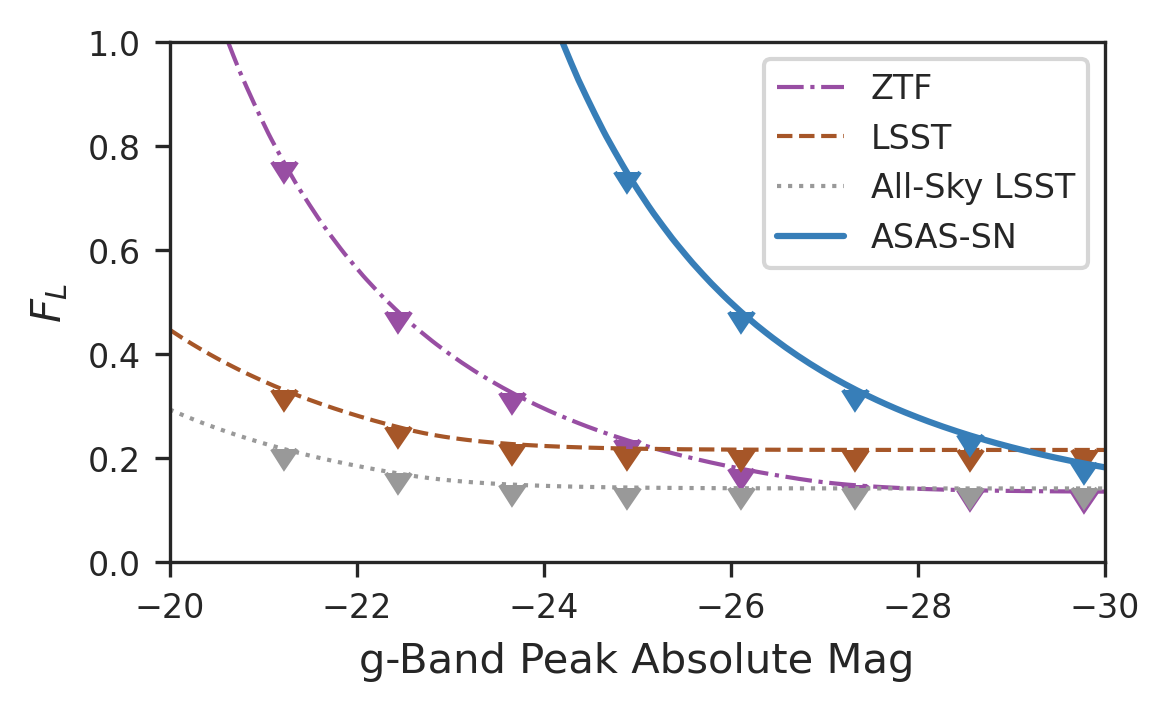

In [194]:
f = cdf_mpc["GRB"]

fig, ax = plt.subplots(
    figsize=(base_width, base_height), 
    dpi=dpi, 
    sharey='all',
    gridspec_kw={'wspace': 0}
)

abs_mag = np.linspace(-20, -31, 1000)

for inst, d in uls.items():
    
    if inst == 'ASAS-SN':
        compmag = asassn_comp_mag
        color = asassn_color
        ls = "-"
        lw = 1.5
    else:
        compmag = instruments[inst][1]
        color = instruments[inst][2]
        ls = instruments[inst][3]
        lw = 1
    
    def max_f(abs_mags):
        res = d[t]/f(max_dl(abs_mags, compmag))
        return res

    ax.plot(abs_mag, max_f(abs_mag), label=inst, color=color, ls=ls, lw=lw)
    mag_scatter = np.linspace(abs_mag[0], abs_mag[-1], 10)[1:-1]
    eb = ax.errorbar(
        mag_scatter, 
        max_f(mag_scatter), 
        yerr=0.0, 
        uplims=True, 
        color=color, 
        linestyle="",
        capsize=0, 
        mew=1
    )
    
ax.set_xlim((max(abs_mag), min(abs_mag)+1))
ax.set_ylim((0, 1))
ax.legend()
ax.set_xlabel('g-Band Peak Absolute Mag')
ax.set_ylabel('$F_{L}$')
fig.tight_layout()
fn = os.path.join(output_folder, "future_inst.pdf")
print(fn)
fig.savefig(fn)

plt.show()